In [1]:
import os
repo_dir = os.environ.get("REPO_DIR")
code_dir = os.path.join(repo_dir, "code/")
data_dir = os.path.join(repo_dir, "data/")
os.chdir(code_dir)

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import pickle
import sklearn 
import sys
import pandas as pd
from importlib import reload

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import seaborn as sns

from scipy.stats import spearmanr

import geopandas as gpd
import cartopy.crs as ccrs
import rasterio

import warnings

from mosaiks.utils.imports import *

# Key prediction functions are here
from analysis.prediction_utils import resize_2d_nonan

# Create Global Maps

Replicating this notebook requires a number of large shapefiles. All data are available for download, but shapefiles are not included in the GitHub repo.

## Let's read in our primary model predictions at the ADM2 level

These are generated in the `hdi_preds_at_adm2.ipynb` notebook.

In [2]:
adm2_shp = pd.read_pickle((data_dir + "preds/" + "hdi_preds_at_adm2.p")) ## Not in GitHub repo, repo only has CSV. Need to merge with ADM2 Geoboundaires
adm2_shp = adm2_shp.to_crs("ESRI:54030")

### Also read our raster estimates

These are generated in the `hdi_preds_at_grid.ipynb` notebook.

In [3]:
raster_outpath = (data_dir + "preds/"
           "hdi_raster_predictions.tif")
src = rasterio.open(raster_outpath)
arr = src.read(1)
ext = np.array(src.bounds)[[0,2,1,3]]

In [4]:
sm_arr = resize_2d_nonan(arr,2,np.median)

(650, 1800)


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## We also need to read in the ADM1 shapefile and data for plotting

In [5]:
gpdf = pd.read_pickle(data_dir + "/int/" +
                    "GDL_HDI/HDI_ADM1_shapefile_clean.p")

raw = pd.read_pickle(data_dir + "/int/" +
                    "GDL_HDI/HDI_indicators_and_indices_clean.p")

gpdf = gpdf.merge(raw, how="left",left_index=True,right_index=True)

gpdf["Sub-national HDI"] = gpdf["Sub-national HDI"].astype(float)

gpdf = gpdf.to_crs("ESRI:54030")

## Also read in the ADM0 shapefile and data

In [6]:
adm0_vals = pd.read_pickle(data_dir + "/int/GDL_HDI/HDI_indicators_and_indices_adm0_clean.p")
adm0 = pd.read_pickle(data_dir + "/int/GDL_HDI/HDI_ADM0_dissolved_shapefile.p")
adm0 = adm0.merge(adm0_vals,how="left", left_index=True, right_index=True)
countries = adm0.to_crs("ESRI:54030")

### Read in a lakes file for masking

In [7]:
lakes = gpd.read_file("/shares/maps100/data/raw/grid/lakes_10m_NaturalEarth/ne_10m_lakes.shp")
lakes = lakes.to_crs("ESRI:54030")

### Now all we need to do is make some plots

In [8]:
adm2_shp_drop_missing = adm2_shp.dropna(subset = ["adjusted_preds"])

In [9]:
rasterized = True
cmap = "plasma"
vmin = gpdf["Sub-national HDI"].min()
vmax = gpdf["Sub-national HDI"].max()


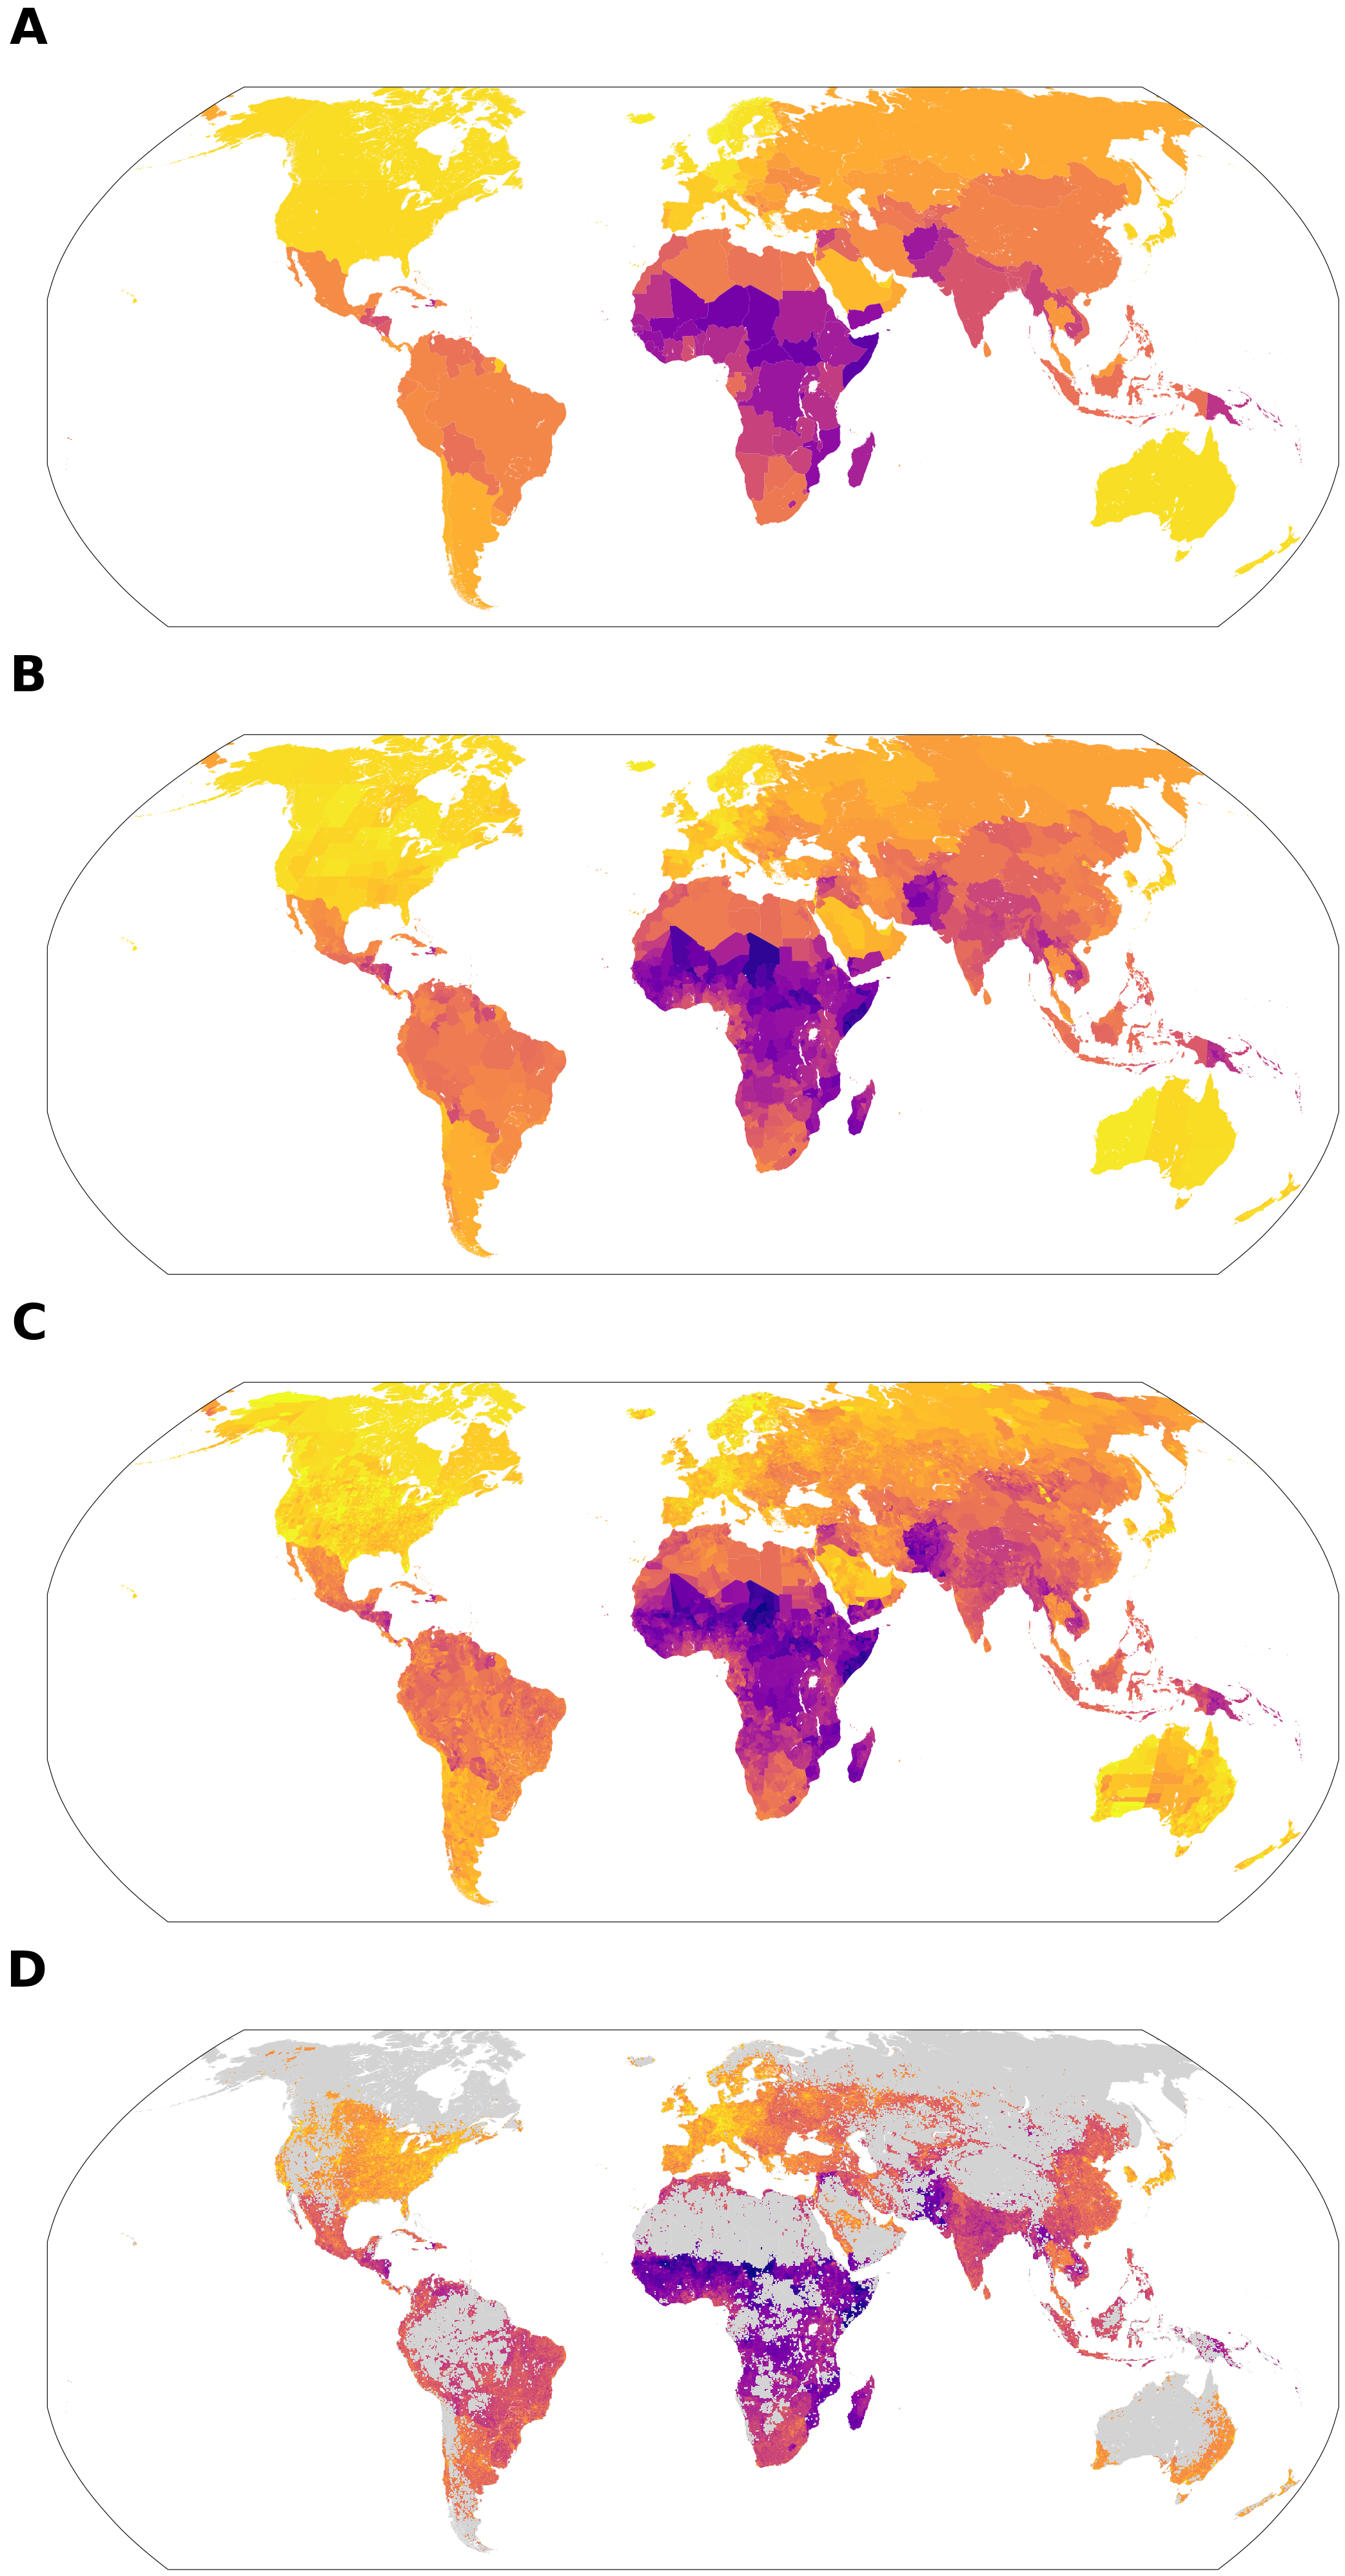

In [10]:
fig, ax = plt.subplots(4,1, figsize = (10*5,5*2*5),subplot_kw={'projection':ccrs.Robinson()})
#################### Plot ADM0 Data
# Backdrop
countries.plot(ax=ax[0], rasterized=rasterized, vmin=vmin, vmax=vmax,column = "Sub-national HDI", cmap=cmap)

#################### Plot ADM1 Data
# Backdrop
gpdf.plot(ax=ax[1], rasterized=rasterized, vmin=vmin, vmax=vmax,column = "Sub-national HDI", cmap=cmap)
# Observed ADM1 values
adm2_shp_drop_missing.plot(ax=ax[1], rasterized=rasterized, vmin=vmin, vmax=vmax,column = "adm1_mean", cmap=cmap, 
                           )


#################### Plot ADM2 preds
## First we plot the background
gpdf.plot(ax=ax[2], rasterized=rasterized, vmin=vmin, vmax=vmax,column = "Sub-national HDI", cmap=cmap)
# Now we plot the re-centered predictions
adm2_shp_drop_missing.plot(ax=ax[2], rasterized=rasterized, vmin=vmin, vmax=vmax,column = "adjusted_preds", cmap=cmap, 
                           legend=False) #,legend_kwds={'loc': 'lower right'})


countries.plot(ax=ax[3], color="lightgrey", zorder=0, rasterized=rasterized,)

a = ax[3].imshow(arr, interpolation=None,
              extent=ext, cmap="plasma", vmin=vmin, vmax=vmax, rasterized=rasterized,
              transform=ccrs.PlateCarree())


for i, letter in enumerate(["A","B","C","D"]):
    ax[i].text(0, 1.15, letter, transform=ax[i].transAxes,
      fontsize=55, fontweight='bold', va='top', ha='right')
    
    ax[i].set_extent((-180,180,-60,74), ccrs.PlateCarree())
    
    ax[i].tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)
    
    lakes.plot(color="white", ax=ax[i], rasterized=True)
    

fig.savefig(repo_dir + "figures/" + "Fig3_global_recentered_on_adm1.pdf", bbox_inches="tight", dpi=300)

## Now we do punch ins

### Africa

In [11]:
left_bound = 4.5
right_bound = 54.5

top_bound = 31.5
lower_bound = -18.5

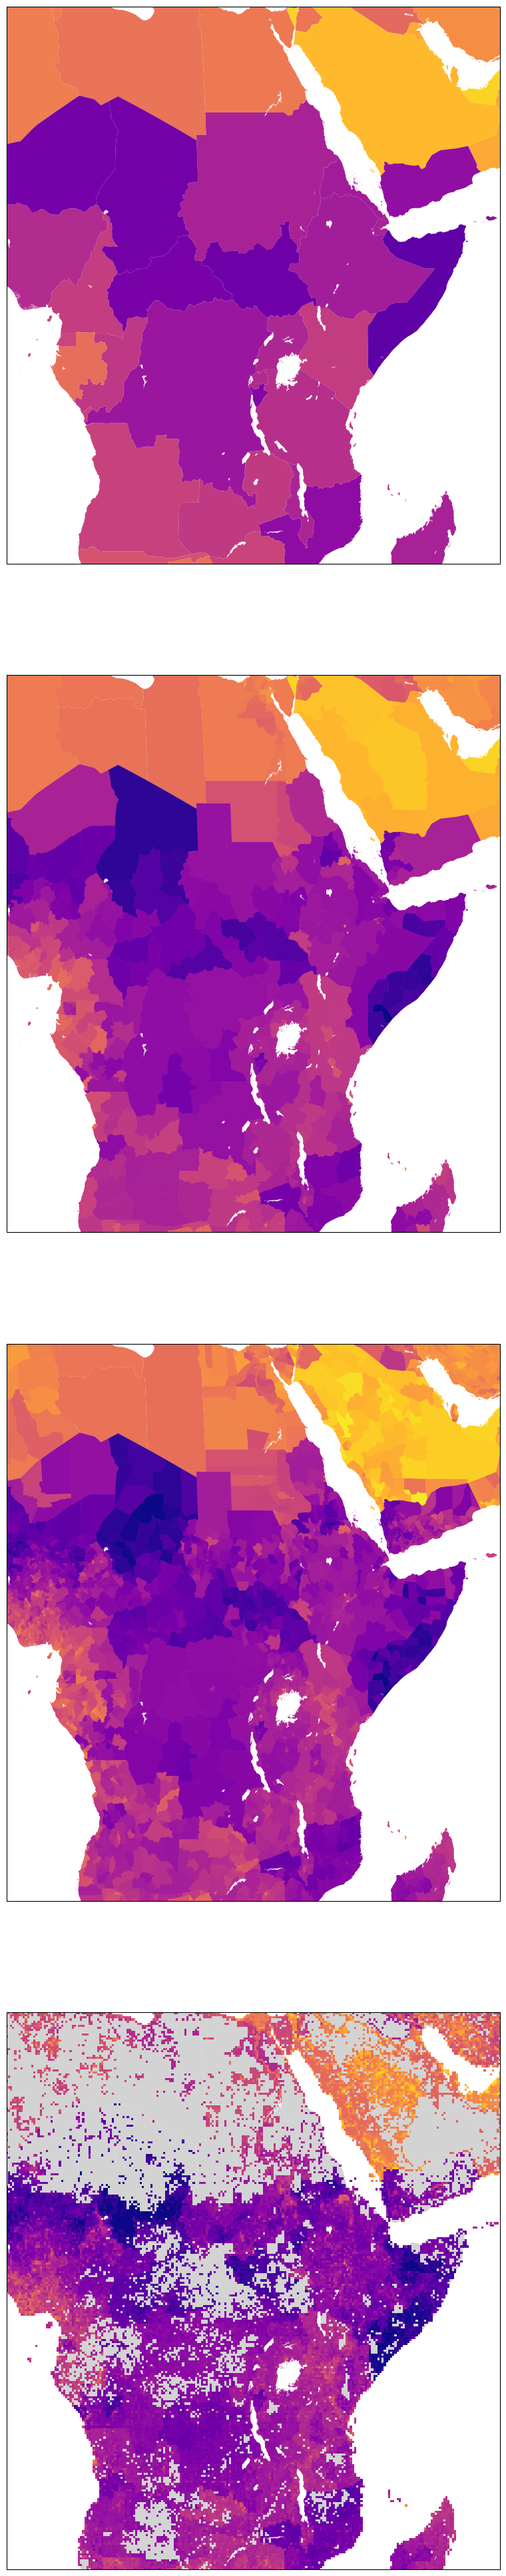

In [12]:
fig, ax = plt.subplots(4,1, figsize = (10*5,5*2*5),subplot_kw={'projection':ccrs.Robinson()})
#################### Plot ADM0 Data
# Backdrop
countries.plot(ax=ax[0], rasterized=rasterized, vmin=vmin, vmax=vmax,column = "Sub-national HDI", cmap=cmap)

#################### Plot ADM1 Data
# Backdrop
gpdf.plot(ax=ax[1], rasterized=rasterized, vmin=vmin, vmax=vmax,column = "Sub-national HDI", cmap=cmap)
# Observed ADM1 values
adm2_shp_drop_missing.plot(ax=ax[1], rasterized=rasterized, vmin=vmin, vmax=vmax,column = "adm1_mean", cmap=cmap, 
                           )


#################### Plot ADM2 preds
## First we plot the background
gpdf.plot(ax=ax[2], rasterized=rasterized, vmin=vmin, vmax=vmax,column = "Sub-national HDI", cmap=cmap)
# Now we plot the re-centered predictions
adm2_shp_drop_missing.plot(ax=ax[2], rasterized=rasterized, vmin=vmin, vmax=vmax,column = "adjusted_preds", cmap=cmap, 
                           legend=False) #,legend_kwds={'loc': 'lower right'})


countries.plot(ax=ax[3], color="lightgrey", zorder=0, rasterized=rasterized,)

a = ax[3].imshow(arr, interpolation=None,
              extent=ext, cmap="plasma", vmin=vmin, vmax=vmax, rasterized=rasterized,
              transform=ccrs.PlateCarree())

for i, letter in enumerate(["A","B","C","D"]):    
    ax[i].set_extent((left_bound,right_bound,lower_bound,top_bound), ccrs.PlateCarree())
    
    ax[i].tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)
    
    lakes.plot(color="white", ax=ax[i], rasterized=True)
    

fig.savefig(repo_dir + "figures/" + "Fig3_africa_recentered_on_adm1.pdf", bbox_inches="tight", dpi=300)

### Asia

In [13]:
left_bound = 72
right_bound = 122
top_bound = 41
lower_bound = -9

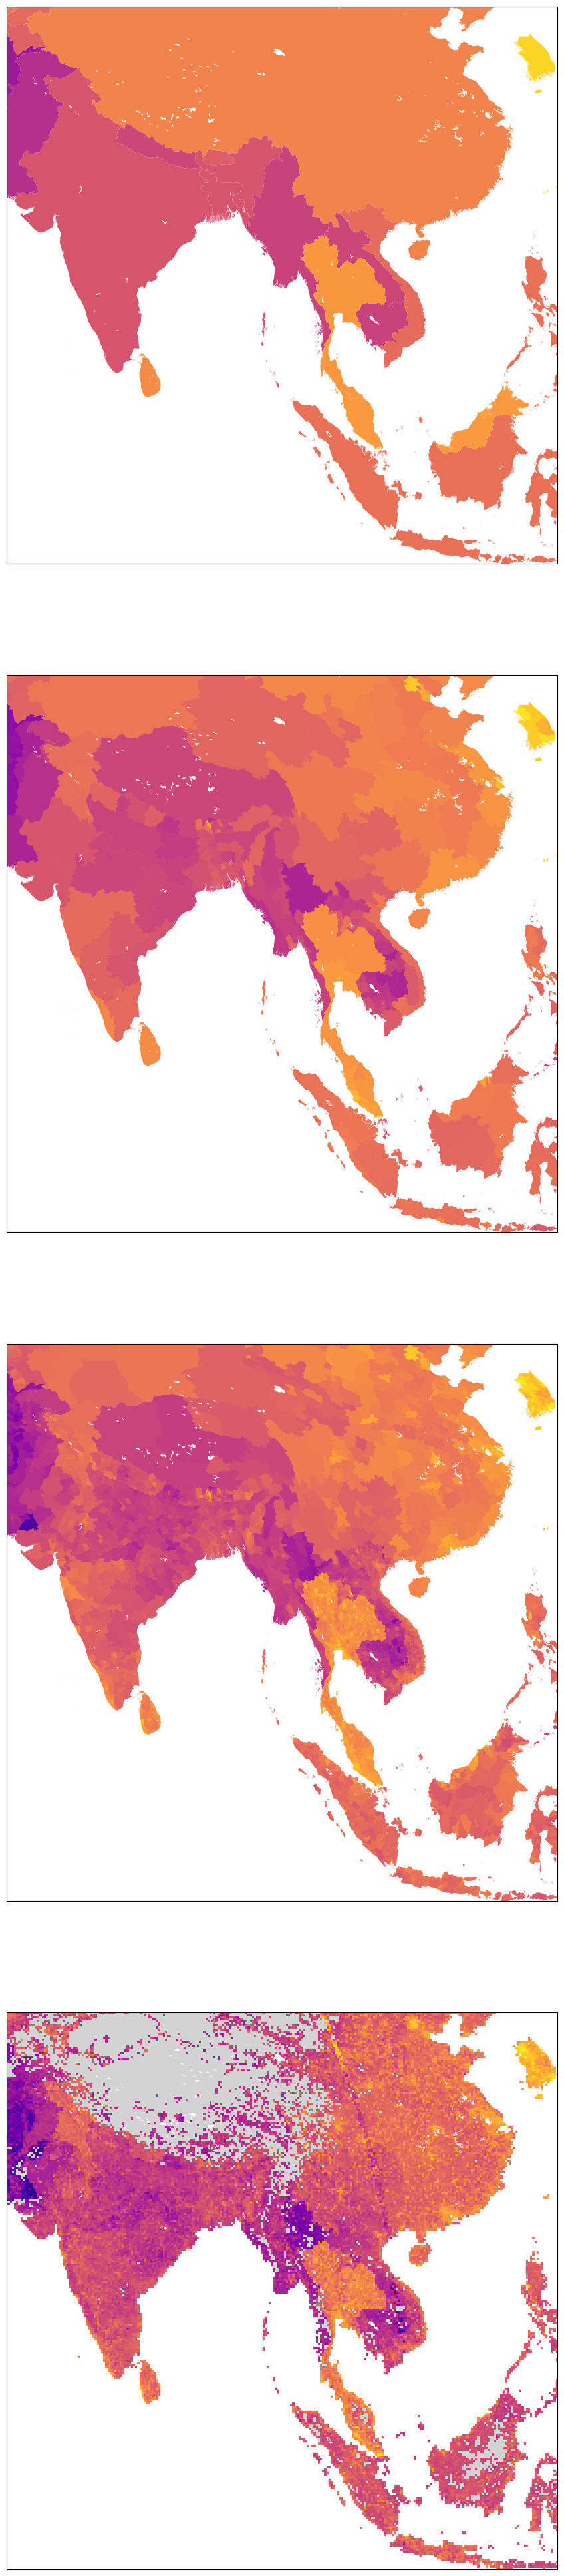

In [14]:
fig, ax = plt.subplots(4,1, figsize = (10*5,5*2*5),subplot_kw={'projection':ccrs.Robinson()})
#################### Plot ADM0 Data
# Backdrop
countries.plot(ax=ax[0], rasterized=rasterized, vmin=vmin, vmax=vmax,column = "Sub-national HDI", cmap=cmap)

#################### Plot ADM1 Data
# Backdrop
gpdf.plot(ax=ax[1], rasterized=rasterized, vmin=vmin, vmax=vmax,column = "Sub-national HDI", cmap=cmap)
# Observed ADM1 values
adm2_shp_drop_missing.plot(ax=ax[1], rasterized=rasterized, vmin=vmin, vmax=vmax,column = "adm1_mean", cmap=cmap, 
                           )


#################### Plot ADM2 preds
## First we plot the background
gpdf.plot(ax=ax[2], rasterized=rasterized, vmin=vmin, vmax=vmax,column = "Sub-national HDI", cmap=cmap)
# Now we plot the re-centered predictions
adm2_shp_drop_missing.plot(ax=ax[2], rasterized=rasterized, vmin=vmin, vmax=vmax,column = "adjusted_preds", cmap=cmap, 
                           legend=False) #,legend_kwds={'loc': 'lower right'})


countries.plot(ax=ax[3], color="lightgrey", zorder=0, rasterized=rasterized,)

a = ax[3].imshow(arr, interpolation=None,
              extent=ext, cmap="plasma", vmin=vmin, vmax=vmax, rasterized=rasterized,
              transform=ccrs.PlateCarree())

for i, letter in enumerate(["A","B","C","D"]):    
    ax[i].set_extent((left_bound,right_bound,lower_bound,top_bound), ccrs.PlateCarree())
    
    ax[i].tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)
    
    lakes.plot(color="white", ax=ax[i], rasterized=True)
    

fig.savefig(repo_dir + "figures/" + "Fig3_asia_recentered_on_adm1.pdf", bbox_inches="tight", dpi=300)

## South America

In [15]:
left_bound = -81
right_bound = -31

top_bound = 11
lower_bound = -39

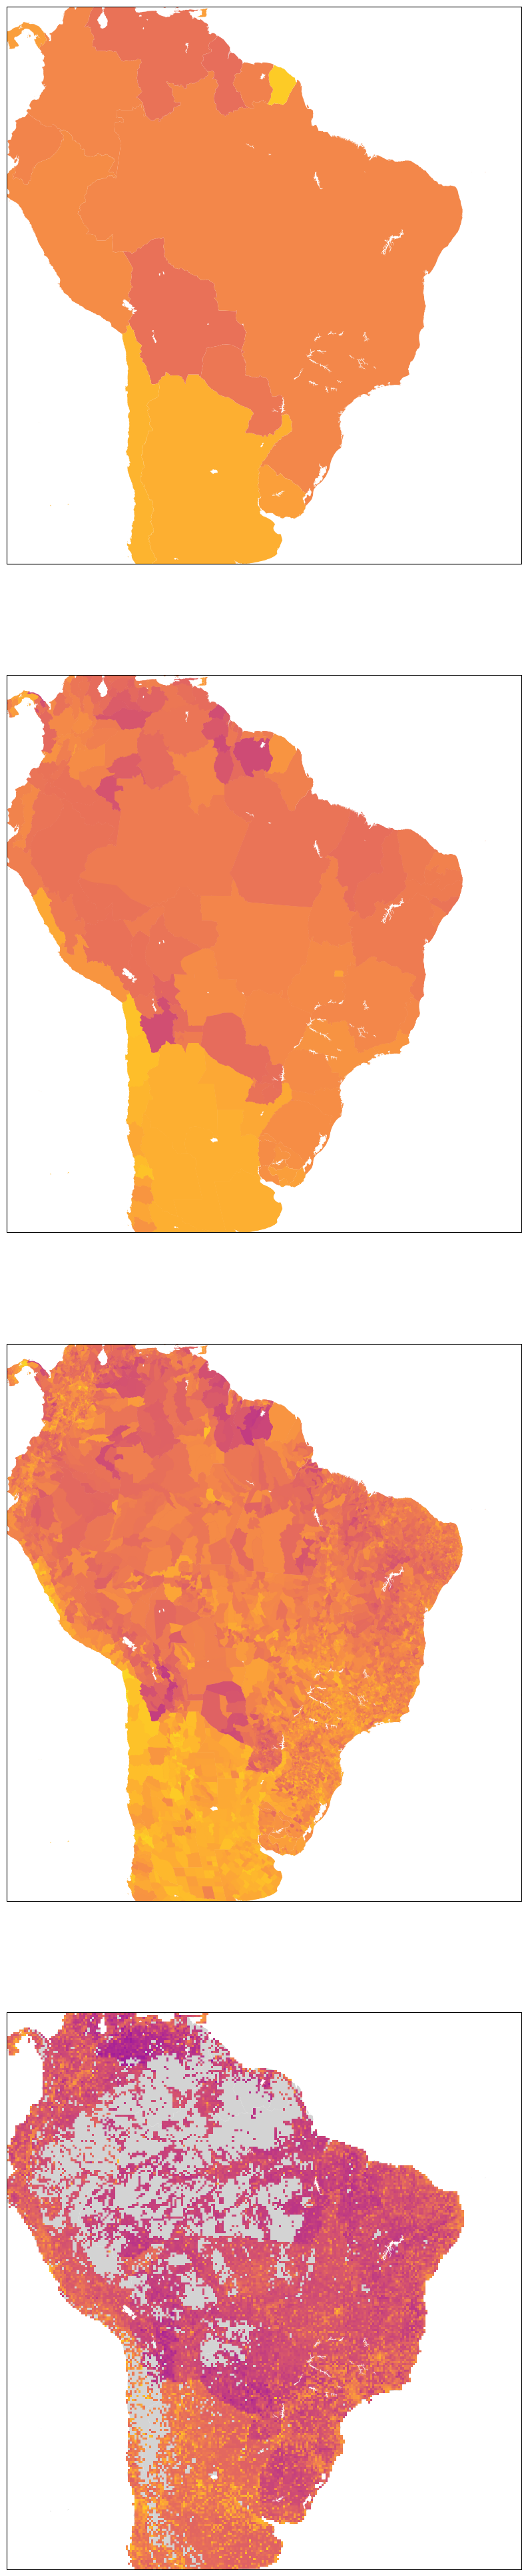

In [16]:
fig, ax = plt.subplots(4,1, figsize = (10*5,5*2*5),subplot_kw={'projection':ccrs.Robinson()})
#################### Plot ADM0 Data
# Backdrop
countries.plot(ax=ax[0], rasterized=rasterized, vmin=vmin, vmax=vmax,column = "Sub-national HDI", cmap=cmap)

#################### Plot ADM1 Data
# Backdrop
gpdf.plot(ax=ax[1], rasterized=rasterized, vmin=vmin, vmax=vmax,column = "Sub-national HDI", cmap=cmap)
# Observed ADM1 values
adm2_shp_drop_missing.plot(ax=ax[1], rasterized=rasterized, vmin=vmin, vmax=vmax,column = "adm1_mean", cmap=cmap, 
                           )


#################### Plot ADM2 preds
## First we plot the background
gpdf.plot(ax=ax[2], rasterized=rasterized, vmin=vmin, vmax=vmax,column = "Sub-national HDI", cmap=cmap)
# Now we plot the re-centered predictions
adm2_shp_drop_missing.plot(ax=ax[2], rasterized=rasterized, vmin=vmin, vmax=vmax,column = "adjusted_preds", cmap=cmap, 
                           legend=False) #,legend_kwds={'loc': 'lower right'})


countries.plot(ax=ax[3], color="lightgrey", zorder=0, rasterized=rasterized,)

a = ax[3].imshow(arr, interpolation=None,
              extent=ext, cmap="plasma", vmin=vmin, vmax=vmax, rasterized=rasterized,
              transform=ccrs.PlateCarree())

for i, letter in enumerate(["A","B","C","D"]):    
    ax[i].set_extent((left_bound,right_bound,lower_bound,top_bound), ccrs.PlateCarree())
    
    ax[i].tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)
    
    lakes.plot(color="white", ax=ax[i], rasterized=True)
    

fig.savefig(repo_dir + "figures/" + "Fig3_southamerica_recentered_on_adm1.pdf", bbox_inches="tight", dpi=300)

### Create high res raster for SI

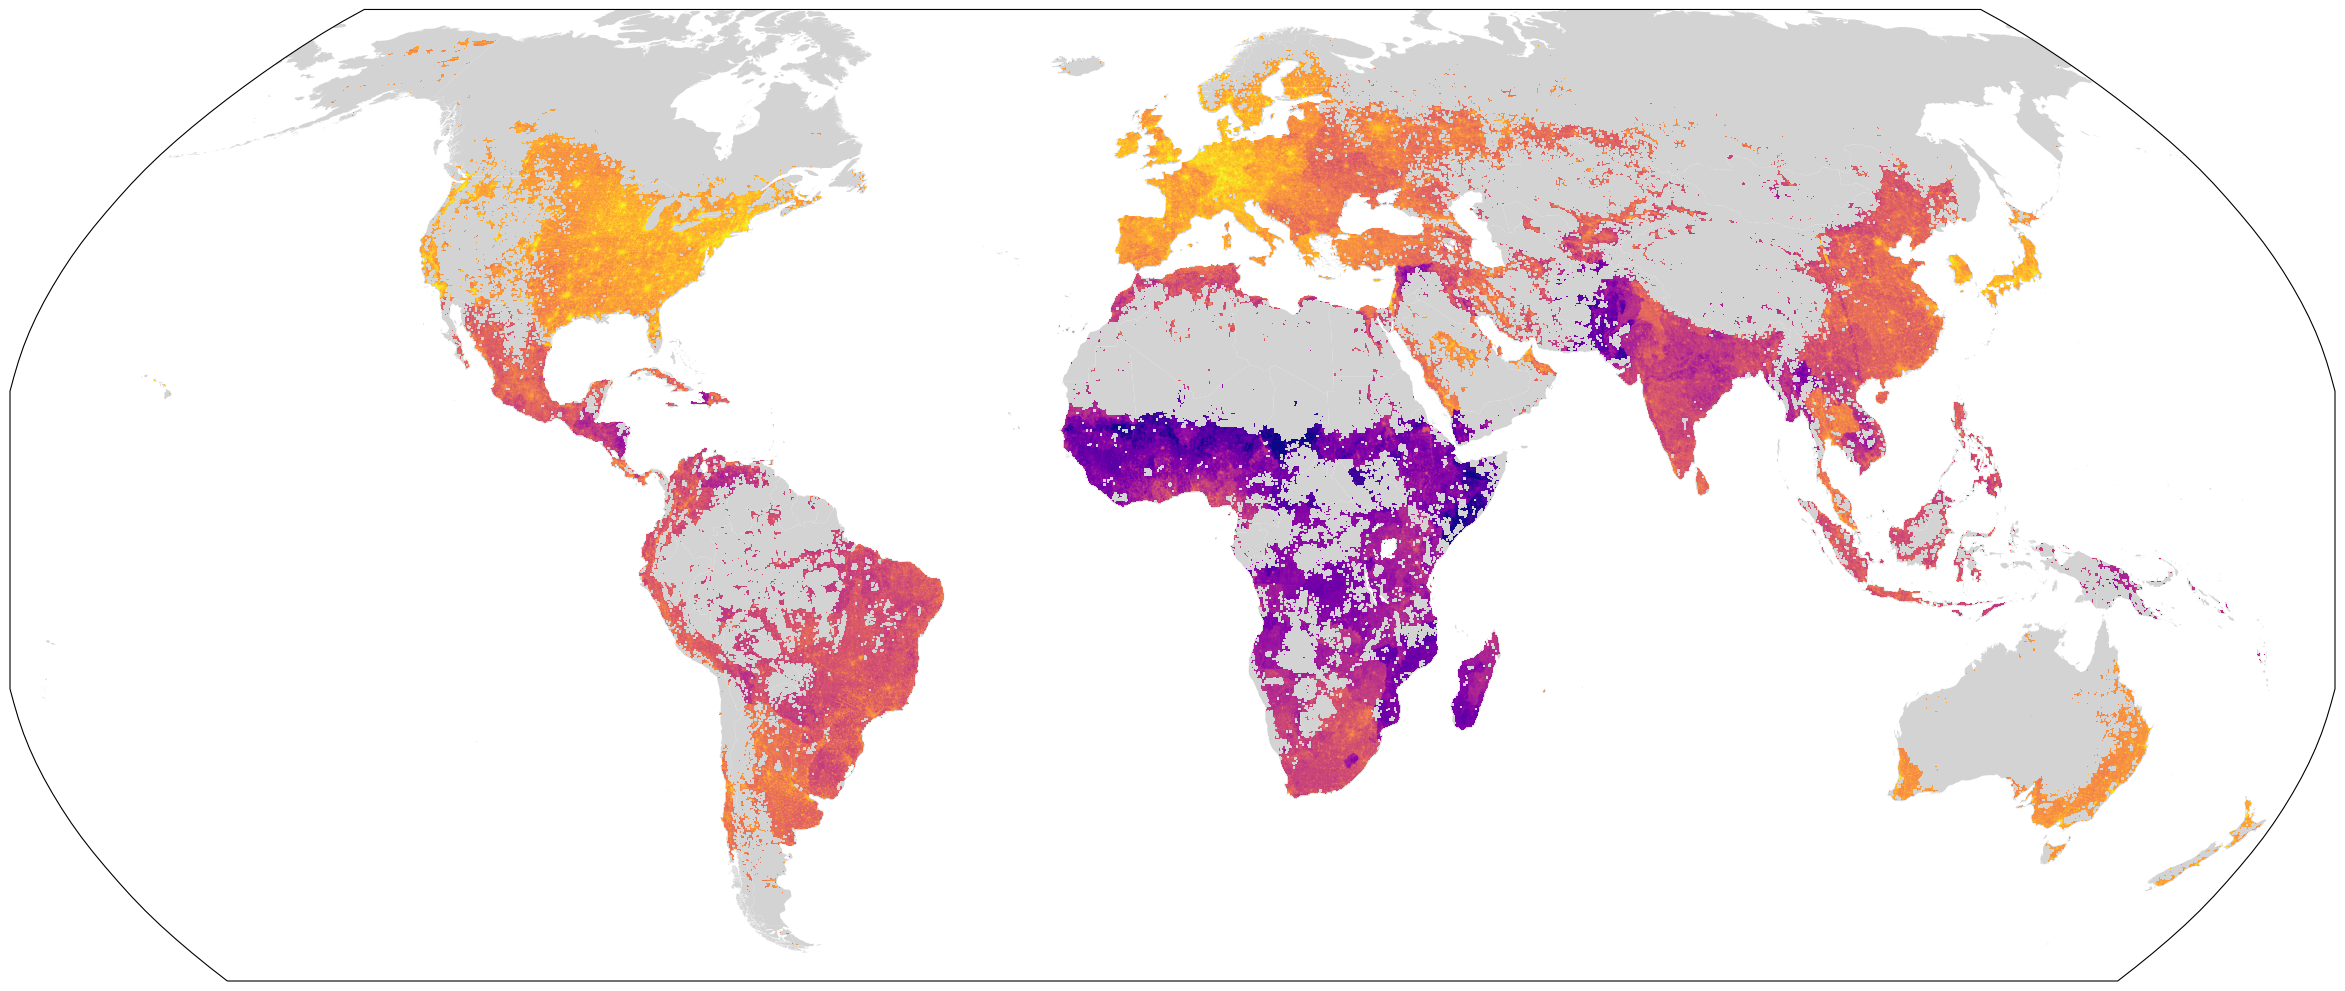

In [17]:
fig, ax = plt.subplots(figsize=(30,30), subplot_kw={'projection':ccrs.Robinson()})
countries.plot(ax=ax, color="lightgrey", zorder=0, rasterized=rasterized,)
ax.imshow(arr,extent=ext, cmap="plasma", vmin=vmin, vmax=vmax,
          rasterized=rasterized, transform=ccrs.PlateCarree(), interpolation=None, 
          regrid_shape=3000)

ax.set_extent((-180,180,-60,74), ccrs.PlateCarree())

fig.savefig(repo_dir + "figures/" + "FigSI_high_res_raster.pdf", bbox_inches="tight", dpi=300)


### Out PNG in Mercator projection (for use on website)

In [18]:
countries = countries.to_crs("EPSG:3857")

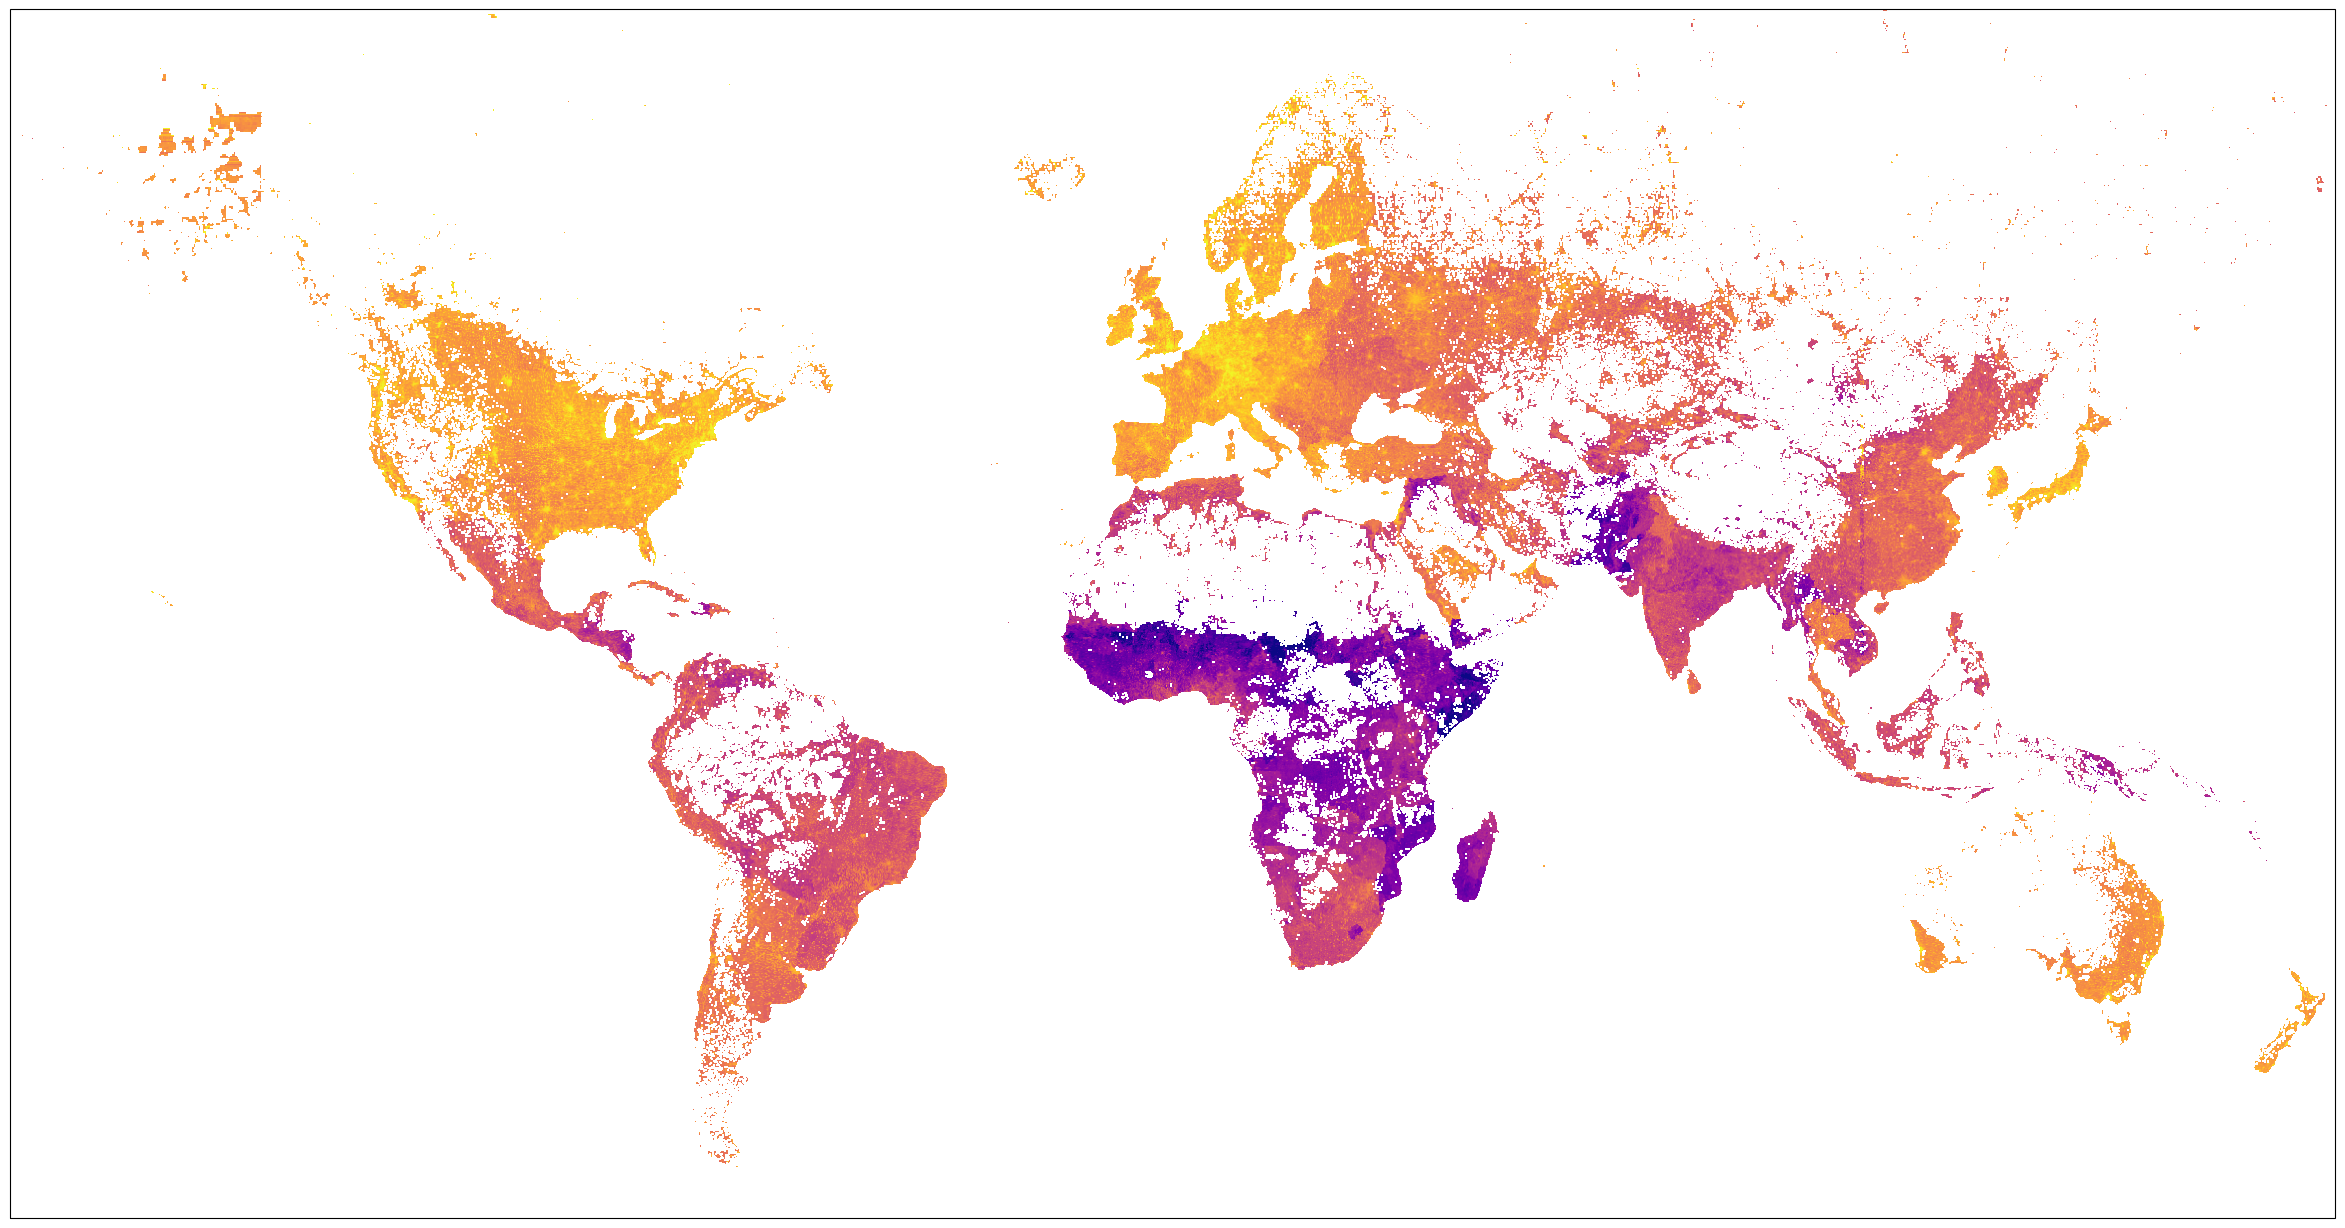

In [19]:
fig, ax = plt.subplots(figsize=(30,30), subplot_kw={'projection':ccrs.Mercator()})

ax.imshow(arr,extent=ext, cmap="plasma", vmin=vmin, vmax=vmax,
          rasterized=rasterized, transform=ccrs.PlateCarree(), interpolation=None, 
          regrid_shape=2000)

ax.set_extent((-180,180,-60,74), ccrs.PlateCarree())

fig.savefig(repo_dir + "figures/" + "raster_mercator.png", bbox_inches="tight", dpi=300, transparent=True)

In [20]:
adm2_shp_drop_missing = adm2_shp_drop_missing.to_crs("EPSG:3857")
gpdf = gpdf.to_crs("EPSG:3857")

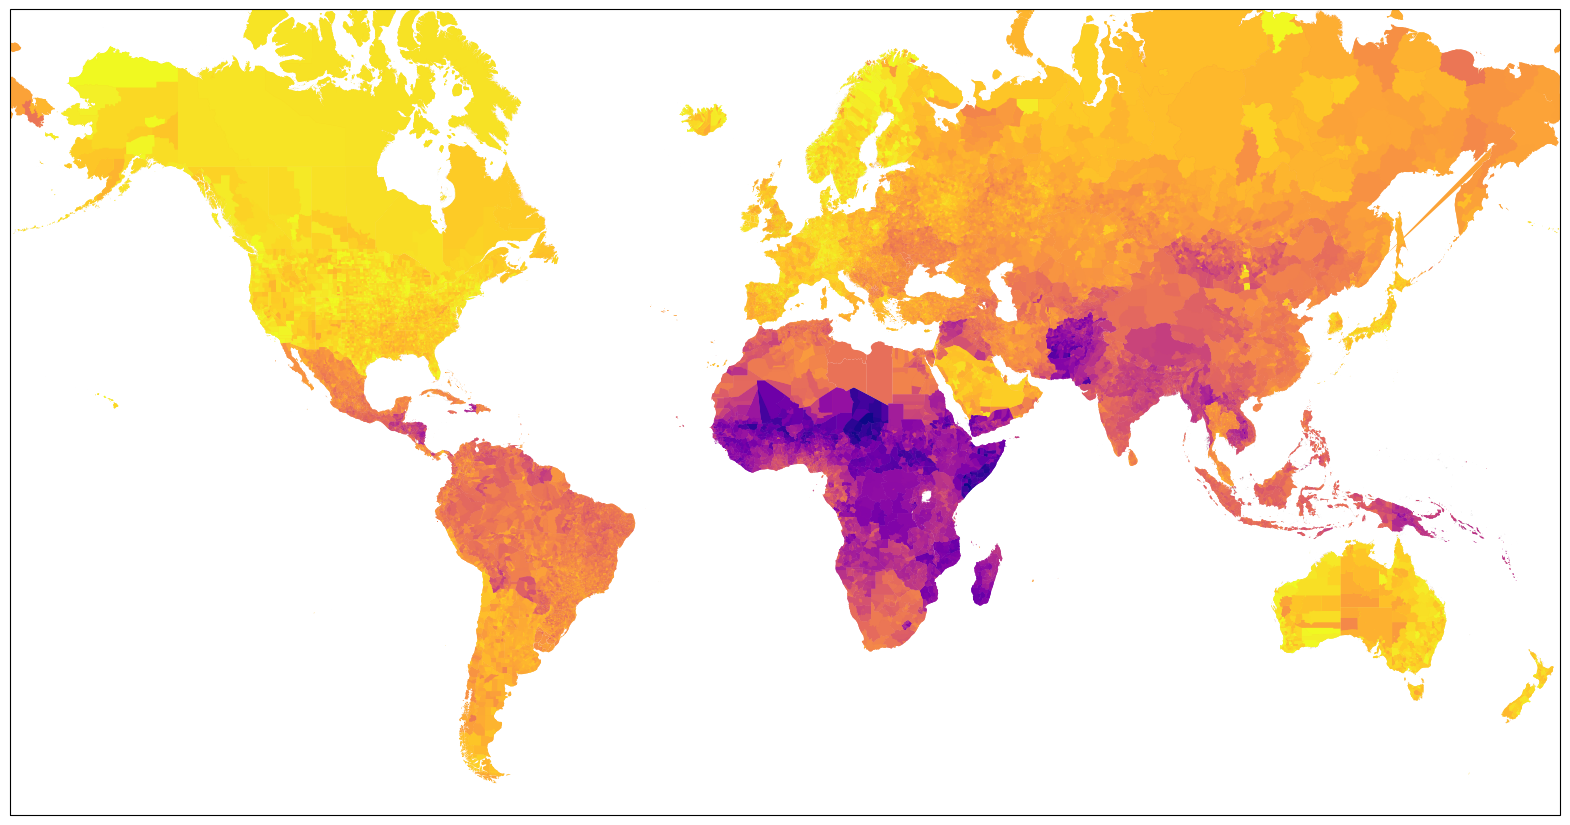

In [21]:
fig, ax = plt.subplots(1, figsize = (20,20),subplot_kw={'projection':ccrs.Mercator()})

# Backdrop
gpdf.plot(ax=ax, rasterized=rasterized, vmin=vmin, vmax=vmax,column = "Sub-national HDI", cmap=cmap)

#################### Plot ADM2 preds
## First we plot the background
adm2_shp_drop_missing.plot(ax=ax, rasterized=rasterized, vmin=vmin, vmax=vmax,column = "adjusted_preds", cmap=cmap, 
                           legend=False) 
    
ax.set_extent((-180,180,-60,74), ccrs.PlateCarree())

    

fig.savefig(repo_dir + "figures/" + "adm2_mercator.png", bbox_inches="tight", dpi=300,transparent=True)